In [2]:
import pandas as pd
from datetime import datetime, timedelta, date
import time
import matplotlib.pyplot as plt
from typing import List
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

#Get the Exchange Rates
exchange_rates_csv = 'exchange_rates.csv'
exchange_rates = pd.read_csv(exchange_rates_csv ,sep=';',parse_dates=[0])
exchange_rates['Date'] = exchange_rates['Date'].apply(lambda x: x.date())
exchange_rates = exchange_rates.set_index('Date')['USD2EUR']
exchange_rates.head()

# Historical Quotes. The most updated start on 2023-08-04
# Lets use 6 months for historical data
quotes_start_date = date(2024, 3, 1)
df_quotes = pd.read_csv("ft_quotes.csv",index_col=0,parse_dates=True).sort_index(ascending=True).ffill().dropna(axis=1).loc[date(2023, 8, 4):]
df_quotes.index = [x.date() for x in df_quotes.index]


# Portofolio on Quotes Start Date
initial_amount = 100
encoding='latin_1'
thousands = ','
decimal = '.'
to_date = lambda d: datetime.strptime(d, '%d-%m-%Y').date()
transacoes_csv = 'transacoes.csv'
converters={'Data de subscricao': to_date}
df_transacoes = pd.read_csv(transacoes_csv ,sep=',',encoding=encoding,thousands=thousands, decimal=decimal, converters=converters, dtype={'Cotacao de Subscricao':float,'Quantidade':float})
df_transacoes['Data de resgate'] = df_transacoes['Data de resgate'].apply(lambda x: datetime.strptime(x, '%d-%m-%Y').date() if pd.notnull(x) else x)
df_transacoes = df_transacoes[df_transacoes['Code'].isin(df_quotes.columns)]
filter = (df_transacoes['Data de subscricao']<=quotes_start_date) & ((pd.isnull(df_transacoes['Data de resgate'])) | (df_transacoes['Data de resgate']>quotes_start_date))
df_transacoes = df_transacoes[filter]
df_transacoes['Amount'] = df_transacoes.apply(lambda x: x['Quantidade']*df_quotes[x['Code']][quotes_start_date] * (exchange_rates.loc[quotes_start_date] if x['Moeda'] == 'USD' else 1), axis=1)
df_portofolio = df_transacoes.groupby('Code')['Amount'].sum()
df_portofolio = df_portofolio * initial_amount  / df_portofolio.sum()

# Parameters
risk_free_rate = 0.03

amount_to_buy = 20
amount_to_sell = 20
final_portfolio_amount = initial_amount + amount_to_buy - amount_to_sell
transaction_amount = 2

n_funds_to_add = 5
max_weight = 0.09

In [3]:
# Select relevant funds
df_perform = pd.read_csv("ft_funds_perform.csv", index_col=0)
relevant_funds = set(df_perform[df_perform['currency'].isin(["EUR","USD"])].index)
relevant_funds &= set([idx for idx in df_perform.index if not idx.startswith("PT")])
relevant_funds &= set(df_quotes.columns)

len(relevant_funds)

3060

In [4]:
from pypfopt.expected_returns import mean_historical_return,ema_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions

In [5]:
#Optimization parameters
transaction_limit = 1


cov_n = 153


### Portfolio Optimization Functions

In [6]:
def new_fund_performance(new_portfolio, new_fund, amount=transaction_amount, risk_free_rate=risk_free_rate, last_n=15, goal='max_sharpe',target=None,weight_bounds = (0,max_weight)):
    if new_fund in new_portfolio.index:
        new_portfolio.loc[new_fund] += amount
    else:
        new_portfolio.loc[new_fund] = amount

    mu = mean_historical_return(df_quotes[new_portfolio.index][-last_n:])
    S = CovarianceShrinkage(df_quotes[new_portfolio.index][-cov_n:]).ledoit_wolf()
    ef = EfficientFrontier(mu, S, weight_bounds=weight_bounds, solver='SCS')
    if goal=='max_sharpe':
        ef.max_sharpe(risk_free_rate=risk_free_rate)
    elif goal=='min_volatility':
        ef.min_volatility()
    elif goal=='efficient_risk':
        ef.efficient_risk(target_volatility=target)
    elif goal=='efficient_return':
        ef.efficient_return(target_return=target)
    else:
        raise ValueError('Invalid Goal!')
    return new_portfolio, ef.portfolio_performance(risk_free_rate=risk_free_rate)

def new_funds_to_add(df_portofolio, selected_funds, n_funds_to_add, goal, last_n, target=None, verbose=False, weight_bounds = (0,1)):

    mu = mean_historical_return(df_quotes[df_portofolio.index][-last_n:])
    S = CovarianceShrinkage(df_quotes[df_portofolio.index][-cov_n:]).ledoit_wolf()

    ef = EfficientFrontier(mu, S, solver='SCS')
    weights = df_portofolio / df_portofolio.sum()
    ef.set_weights(weights)

    current_return, current_volatility, current_sharpe_ratio = ef.portfolio_performance(risk_free_rate=risk_free_rate)

    max_sharpe = current_sharpe_ratio
    min_volatility = current_volatility
    amount = transaction_amount
    funds_to_buy = []
    performance = None

    current_portfolio = df_portofolio.copy()
    for i in range(n_funds_to_add):
        best_fund = None
        for new_fund in selected_funds:
            try:
                _, (new_return,new_volatility,new_sharpe) = new_fund_performance(
                                                    new_portfolio=current_portfolio.copy(),
                                                    new_fund=new_fund,
                                                    last_n=last_n,
                                                    goal=goal,
                                                    target=target)
                if ((goal == 'max_sharpe') or (goal == 'efficient_risk')) and (new_sharpe > max_sharpe):
                    max_sharpe = new_sharpe
                    best_fund = new_fund
                if ((goal == 'min_volatility') or (goal == 'efficient_return')) and (new_volatility < min_volatility):
                    min_volatility = new_volatility
                    best_fund = new_fund
            except Exception as e:
                raise e
                pass
        
        if best_fund is None:
            print("\nNo more Funds found!")
            break
        else:
            funds_to_buy.append(best_fund)
            current_portfolio, performance = new_fund_performance(
                new_portfolio=current_portfolio,
                new_fund=best_fund,
                last_n=last_n,
                goal=goal,
                target=target)
            if verbose:
                print("### Performance with ", best_fund)
                print(df_perform.loc[best_fund][['ft category','name']])
                print(performance)
    return funds_to_buy, performance

def portfolio_strategy(dfi, ef, prev_strategy=None):
    cleaned_weights = ef.clean_weights()
    cleaned_weights = [(s,w) for s,w in cleaned_weights.items()]
    dfo = pd.DataFrame(cleaned_weights,columns=['Code','w']).sort_values(by='w',ascending=False)
    df = pd.merge(dfi,dfo,on=['Code'],how='outer',suffixes=('_i','_o')).fillna(0)
    if prev_strategy is not None:
        df['strategy'] =  df.apply(lambda x: prev_strategy.loc[x['Code']]['strategy'], axis=1)
    else:
        df['strategy'] = 'c'
    df['final_amount'] = df.apply(lambda x: x['amount'] if x['strategy']=='k' else x['w_o']*final_portfolio_amount, axis=1)
    df['change_amount'] = df['final_amount'] - df['amount']

    return df

def valid_date(d: date) -> date:
    if d in df_quotes.index:
        return d
    return max(dd for dd in df_quotes.index if dd <= d)

def next_date(current_date: date, transaction_interval: int = 7) -> date:
    return valid_date(current_date + timedelta(days=transaction_interval))

def fund_selection_1(df_portofolio: pd.Series,current_date: date) -> set:
    old_date = valid_date(current_date - timedelta(days=14))
    df_perform['2w'] = df_quotes.loc[current_date]/df_quotes.loc[old_date]
    selected_funds = set(df_perform[df_perform.groupby('ft category')['2w'].transform('max')==df_perform['2w']].index)
    selected_funds |= set(df_perform[df_perform['rating'] >= 5].index)
    selected_funds -= set(df_portofolio.index)
    return selected_funds & relevant_funds

def my_ef(df_portofolio: pd.Series, current_date: date, last_n: int, span:int):
    mu = ema_historical_return(df_quotes[df_portofolio].loc[valid_date(current_date - timedelta(days=last_n)):current_date],span=span)
    S = CovarianceShrinkage(df_quotes[df_portofolio].loc[valid_date(current_date - timedelta(days=cov_n)):current_date]).ledoit_wolf()
    return mu, S

def strategy_step(df_portofolio: pd.Series, current_date: date, fn_selection, last_n: int, span: int, new_date: date, last_n_2: int) -> pd.Series:
    
    mu, S = my_ef(df_portofolio=df_portofolio.index,current_date=current_date,last_n=last_n,span=span)
    ef = EfficientFrontier(mu, S, solver='SCS')
    weights = df_portofolio / df_portofolio.sum()
    ef.set_weights(weights)
    dfi = pd.DataFrame({'w':weights, 'amount':df_portofolio}).reset_index().sort_values(by='w',ascending=False)

    new_portfolio = df_portofolio.copy()

    funds_to_buy, performance = new_funds_to_add(
        df_portofolio=new_portfolio,
        selected_funds=fn_selection(df_portofolio=new_portfolio,current_date=current_date), 
        n_funds_to_add=n_funds_to_add,
        last_n=last_n_2,
        goal='max_sharpe',
        verbose=False,
        weight_bounds=(0,max_weight))

    new_p = new_portfolio.index.append(pd.Index(funds_to_buy))

    mu, S = my_ef(df_portofolio=new_p,current_date=current_date,last_n=last_n,span=span)
    ef = EfficientFrontier(mu, S, weight_bounds=(0,max_weight), solver='SCS')
    ef.max_sharpe(risk_free_rate=risk_free_rate)

    df = portfolio_strategy(dfi=dfi,ef=ef).set_index('Code')

    weight_bounds = list()
    buy_list = list()
    for i, code in enumerate(df_quotes[new_p].columns):
        if abs(df.loc[code]['change_amount']) < transaction_limit:
            weight_bounds.append((df.loc[code]['w_i'],df.loc[code]['w_i'])) # Keep
        elif df.loc[code]['change_amount'] >= 0.0:
            weight_bounds.append((df.loc[code]['w_i'],max_weight)) # keep or buy
        else:
            weight_bounds.append((0.0,df.loc[code]['w_i'])) #keep or sell
        if df.loc[code]['change_amount'] >= 0.0:
            buy_list.append((i,df.loc[code]['w_i']))

    mu, S = my_ef(df_portofolio=new_p,current_date=current_date,last_n=last_n,span=span)
    ef = EfficientFrontier(mu, S, weight_bounds=weight_bounds, solver='SCS')
    # Limit the amount to buy
    buy_final_w = (sum([w_i for _,w_i in buy_list])*initial_amount + amount_to_buy) / final_portfolio_amount
    ef.add_constraint(lambda x : sum([x[i] for i,_ in buy_list]) == buy_final_w)
    try:
        ef.max_sharpe(risk_free_rate=risk_free_rate)
    except Exception as e:
        ef = EfficientFrontier(mu, S, weight_bounds=weight_bounds, solver='SCS')
        ef.max_sharpe(risk_free_rate=risk_free_rate)

    df = portfolio_strategy(dfi=dfi,ef=ef).set_index('Code')
    df['w_o'] = df.apply(lambda x: x['w_i'] if abs(x['change_amount'])<transaction_limit else x['w_o'], axis = 1)
    r = 1- (df['w_o'].sum()-1) / df[(df['w_o']!=df['w_i'])]['w_o'].sum()
    df['w_o'] = df.apply(lambda x: x['w_o']*(1 if x['w_o']==x['w_i'] else r) ,axis=1)

    ds = df['w_o']*df['amount'].sum()
    ds = ds[ds!=0]
    ds.name = 'amount'

    df = ds.reset_index()
    df['new_amount'] = df.apply(lambda x: x['amount']*df_quotes[x['Code']][new_date]/df_quotes[x['Code']][current_date],axis=1)
    
    return df.set_index('Code')['new_amount']

2024-03-01
2024-03-08
2024-03-15
2024-03-22
2024-03-29
2024-04-05
2024-04-12
2024-04-19
2024-04-26
2024-05-03
2024-05-10


<Axes: xlabel='date'>

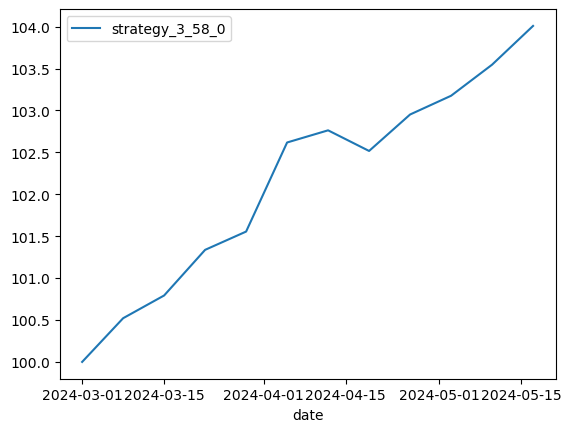

In [7]:
current_date = valid_date(d=quotes_start_date)
new_date = next_date(current_date)
value_lst = [(current_date,initial_amount)]
df_prtf = df_portofolio

while new_date < df_quotes.index.max():
    print(current_date)
    df_prtf = strategy_step(df_portofolio=df_prtf,current_date=current_date,fn_selection=fund_selection_1, last_n=58, span=3,new_date=new_date, last_n_2=58)
    value_lst.append((new_date,df_prtf.sum()))
    current_date = new_date
    new_date = next_date(current_date)

results_df = pd.DataFrame(data=value_lst,columns=['date','strategy_3_58_0']).set_index('date')
results_df.plot()

2024-03-01
2024-03-08
2024-03-15
2024-03-22
2024-03-29
2024-04-05
2024-04-12
2024-04-19
2024-04-26
2024-05-03
2024-05-10


<Axes: xlabel='date'>

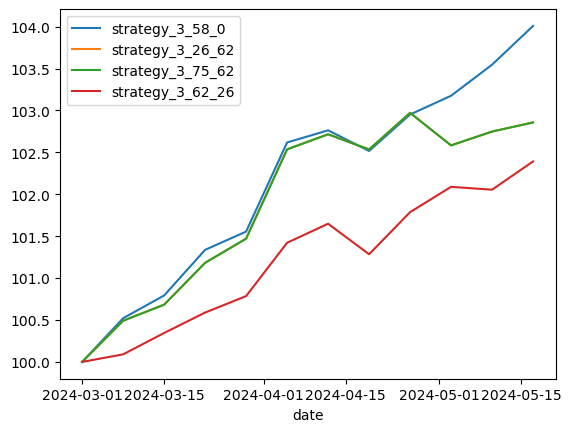

In [10]:
last_n, span, last_n_2 = 62, 3, 26
current_date = valid_date(d=quotes_start_date)
new_date = next_date(current_date)
value_lst = [(current_date,initial_amount)]
df_prtf = df_portofolio

while new_date < df_quotes.index.max():
    print(current_date)
    df_prtf = strategy_step(df_portofolio=df_prtf,current_date=current_date,fn_selection=fund_selection_1, last_n=last_n, span=span,new_date=new_date, last_n_2=last_n_2)
    value_lst.append((new_date,df_prtf.sum()))
    current_date = new_date
    new_date = next_date(current_date)

results_df = results_df.join(pd.DataFrame(data=value_lst,columns=['date',f'strategy_{span}_{last_n}_{last_n_2}']).set_index('date'))
results_df.plot()

In [23]:
results_df

,strategy_3_58_0,strategy_3_58,strategy_3_58_15,strategy_3_58_48,strategy_3_58_70,strategy_3_58_62,strategy_3_58_58
date,,,,,,,
2024-03-01,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2024-03-08,100.521476,100.521476,100.522299,100.464175,101.049709,100.491370,100.521476
2024-03-15,100.792642,100.792642,100.670350,100.709980,101.274537,100.682876,100.792642
2024-03-22,101.302108,101.336965,101.015153,101.200264,101.593546,101.182267,101.336965
2024-03-29,101.473774,101.554957,101.050185,101.452663,101.844867,101.470418,101.554957
2024-04-05,102.478253,102.617667,102.066123,102.215241,103.027846,102.535719,102.617667
2024-04-12,102.627777,102.762658,102.216147,102.442994,103.231470,102.715185,102.762658
2024-04-19,102.495097,102.516551,101.870350,102.232551,103.175047,102.534471,102.516551
2024-04-26,102.889387,102.951355,102.211591,102.515461,103.233047,102.970935,102.951355
